In [1]:
import os

download_name = "worldcities_with_splits.csv.zip"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a03/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "worldcities_with_splits.csv"
if not os.path.exists(name):
    from zipfile import ZipFile
    with ZipFile(download_name) as zf:
        zf.extract(name)

del download_name, name   

# SOLUTION: Classifying Cities with a Multilayer Perceptron

## Imports

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

#from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [3]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def ordered_tokens(self):
        tokens = []
        for idx in sorted(self._idx_to_token):
            tokens.append(self.lookup_index(idx))
        return tokens

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

👍 Implement `vectorize()`method which must return one-hot matrix where each column is one-hot vector of city's letters in order of appearance. Maximum number of columns is delimited by `max_city_length` attribute.

In [4]:
class CityVectorizer(object):
    def __init__(self, city_vocab, country_vocab, max_city_length):
        self.city_vocab = city_vocab
        self.country_vocab = country_vocab
        self.max_city_length = max_city_length

    def vectorize(self, city):
        one_hot_matrix_size = (len(self.city_vocab), 
                               self.max_city_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
        
        for position_index, character in enumerate(city[:self.max_city_length]):
            character_index = self.city_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1
        
        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, city_df):
        city_vocab = Vocabulary(unk_token="@")
        country_vocab = Vocabulary(add_unk=False)
        max_city_length = 0

        for index, row in city_df.iterrows():
            max_city_length = max(max_city_length, len(row.city))
            for letter in row.city:
                city_vocab.add_token(letter)
            country_vocab.add_token(row.country)

        return cls(city_vocab, country_vocab, max_city_length)

    @classmethod
    def from_serializable(cls, contents):
        city_vocab = Vocabulary.from_serializable(contents['city_vocab'])
        country_vocab =  Vocabulary.from_serializable(contents['country_vocab'])
        max_city_length =  Vocabulary.from_serializable(contents['max_city_length'])
        return cls(city_vocab=city_vocab, country_vocab=country_vocab, max_city_length=max_city_length)

    def to_serializable(self):
        return {'city_vocab': self.city_vocab.to_serializable(),
                'country_vocab': self.country_vocab.to_serializable(),
                'max_city_length': self.max_city_length}

### The Dataset

In [5]:
class CityDataset(Dataset):
    def __init__(self, city_df, vectorizer):
        self.city_df = city_df
        self._vectorizer = vectorizer

        self.train_df = self.city_df[self.city_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.city_df[self.city_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.city_df[self.city_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = city_df.country.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.country_vocab.lookup_token(item[0])

        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.frequencies = torch.tensor(frequencies, dtype=torch.float32)
        self.class_weights = 1.0 / torch.log(self.frequencies)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, city_csv):
        city_df = pd.read_csv(city_csv)
        train_city_df = city_df[city_df.split=='train']
        return cls(city_df, CityVectorizer.from_dataframe(train_city_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, city_csv, vectorizer_filepath):
        city_df = pd.read_csv(city_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(city_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return CityVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        city_vector = self._vectorizer.vectorize(row.city)

        country_index = self._vectorizer.country_vocab.lookup_token(row.country)

        return {'x_city': city_vector,
                'y_country': country_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: CityClassifier

👍 Create `CityClassifier` class as MLP with single hidden layer. Methods are:
* `__init__(self, in_channel, in_dim, conv_channels, conv_kernel_sizes, conv_strides, conv_activation, out_dim)` initializes perceptron with
* input channel (the first input channel size - row number of one-hot matrix)
* input dimension (column number of one-hot matrix)
* list of 1D convolution output/input channels, kernel sizes and strides, 
* convolution activation function.
* output dimension (should be the number of output classes)

For example, 
`__init__(in_channel=10, in_dim=15, conv_channels=[16, 32, 64], conv_kernel_sizes=[2, 3, 2], conv_strides=[1, 2, 1], conv_activation, out_dim=6)`
will create three 1D convolution layers with activations after each:
* conv1 with 10 input channels (in_channel argument), 16 output channels, kernel size 2, stride 1 following by activation,
* conv2 with 16 input channels, 32 output channels, kernel size 3, stride 2 followed by activation,
* conv3 with 32 input channels, 64 output channels, kernel size 2, stride 1 (outputs feature vector) followed by activation.

and single fully connected layer fc:
* with input size X (size of flattened output features vector from the last convolutional layer, must be computed by applying convolutions on `in_dim`)
* and output size 6 (this is the number of output classes)


* `forward(self, x_in, apply_softmax=False)` for given input `x_in` makes forward step and eventually applies softmax on output. 

In [6]:
class CityClassifier(nn.Module):

    def __init__(self, in_channel, in_dim, conv_channels, conv_kernel_sizes, conv_strides, conv_activation, out_dim):
        super(CityClassifier, self).__init__()   

        assert len(conv_channels) == len(conv_kernel_sizes) == len(conv_strides)

        feature_dim = in_dim
        seq = []
        prev_num_channels = in_channel
        for num_channels, kernel_size, stride in zip(conv_channels, conv_kernel_sizes, conv_strides):
            seq.append(nn.Conv1d(in_channels=prev_num_channels, 
                                 out_channels=num_channels, 
                                 kernel_size=kernel_size, 
                                 stride=stride))
            seq.append(conv_activation())
            
            feature_dim = (feature_dim - kernel_size) // stride + 1
            prev_num_channels = num_channels

        self.convnet = nn.Sequential(*seq)
        
        feature_dim *= prev_num_channels
        self.fc = nn.Linear(in_features=feature_dim, out_features=out_dim)

    def forward(self, x_in, apply_softmax=False):
        features = self.convnet(x_in).flatten(start_dim=1)
        prediction_vector = self.fc(features)
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)
        return prediction_vector
        
# model = CityClassifier(10, 15, [16, 32, 64], [2, 3, 2], [1, 2, 1], nn.ReLU, 6)
# x_in = torch.rand(size=(2,10,15))
# model(x_in)
# print(model)


## Training Routine

### Helper functions

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            torch.save(model.state_dict(), train_state['model_filename'])
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [8]:
def set_seed_everywhere(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [9]:
args = Namespace(
    # Data and path information
    city_csv="worldcities_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir=".",
    # Model hyper parameters
    conv_channels=[256, 256, 256, 256],
    conv_kernel_sizes = [3, 3, 3, 3],
    conv_strides = [1, 2, 2, 1],
    conv_activation = nn.ReLU,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
    print("Expanded filepaths: ")
    print(f"\t{args.vectorizer_file}")
    print(f"\t{args.model_state_file}")
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print(f"Using CUDA: {args.cuda}")


# Set seed for reproducibility
set_seed_everywhere(args.seed)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	./vectorizer.json
	./model.pth
Using CUDA: False


### Initializations

In [10]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = CityDataset.load_dataset_and_load_vectorizer(args.city_csv,   
                                                           args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = CityDataset.load_dataset_and_make_vectorizer(args.city_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = CityClassifier(in_channel=len(vectorizer.city_vocab), 
                            in_dim=vectorizer.max_city_length,
                            conv_channels=args.conv_channels,
                            conv_kernel_sizes=args.conv_kernel_sizes,
                            conv_strides=args.conv_strides,
                            conv_activation=args.conv_activation,
                            out_dim=len(vectorizer.country_vocab))

classifier


Creating fresh!


CityClassifier(
  (convnet): Sequential(
    (0): Conv1d(199, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (3): ReLU()
    (4): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (5): ReLU()
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (7): ReLU()
  )
  (fc): Linear(in_features=1536, out_features=80, bias=True)
)

### Training loop

In [11]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)


loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                 total=args.num_epochs,
                 position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                 total=dataset.get_num_batches(args.batch_size), 
                 position=1, 
                 leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
               total=dataset.get_num_batches(args.batch_size), 
               position=1, 
               leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_city'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_country'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_country'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_city'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_country'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_country'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/442 [00:00<?, ?it/s]

split=val:   0%|          | 0/94 [00:00<?, ?it/s]

Exiting loop


## Test

In [12]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_city'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_country'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_country'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [13]:
print(f"Test loss: {train_state['test_loss']}")
print(f"Test Accuracy: {train_state['test_acc']}")

Test loss: 2.803209503491719
Test Accuracy: 53.32031250000001


### Losses

👍 Plot train and validation losses. Losses are stored in `train_state`.

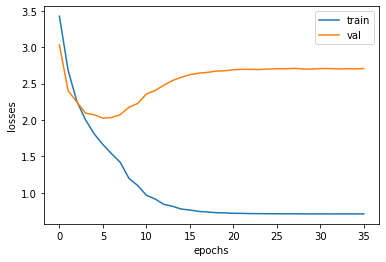

In [28]:
plt.xlabel("epochs")
plt.ylabel("losses")

plt.plot(train_state["train_loss"], label="train")
plt.plot(train_state["val_loss"], label="val")
plt.legend()

### Confusion matrix
👍 Plot confusion matrix for test split.

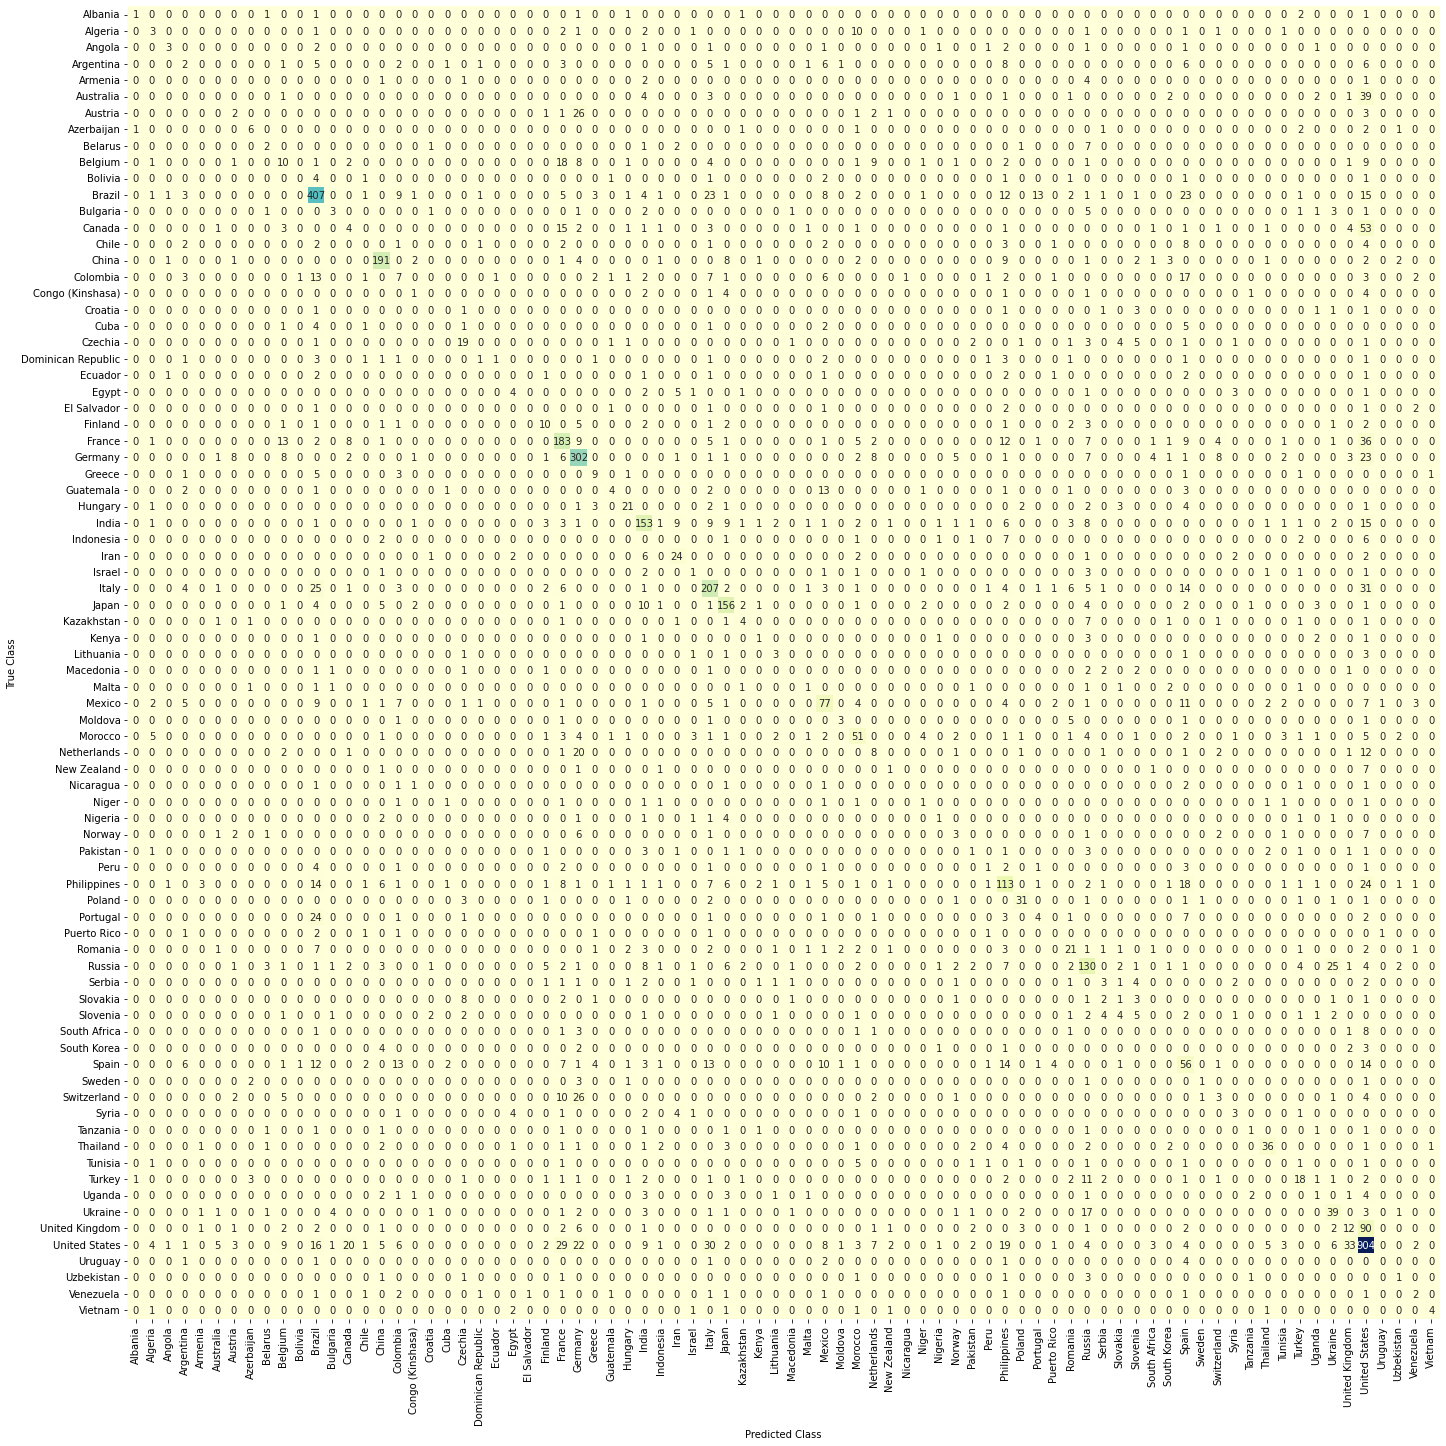

In [14]:
dataset.set_split('test')

data = next(generate_batches(dataset, len(dataset)))
x_data, y_truth = data["x_city"], data["y_country"]
y_pred = classifier(x_data, apply_softmax=True).argmax(dim=1)

countries = list(vectorizer.country_vocab._token_to_idx)

conf_df = pd.DataFrame(confusion_matrix(y_truth, y_pred), index=countries, columns=countries)

plt.figure(figsize=(20,20))
sns.heatmap(conf_df, annot=True, cbar=None, cmap="YlGnBu", fmt="d")
plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

### Inference

In [29]:
def predict_country(city, classifier, vectorizer):
    vectorized_city = vectorizer.vectorize(city)
    vectorized_city = torch.tensor(vectorized_city).unsqueeze(0)
    result = classifier(vectorized_city, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_country = vectorizer.country_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'country': predicted_country, 'probability': probability_value}

predict_country("Split", classifier, vectorizer)


{'country': 'Armenia', 'probability': 0.3117449879646301}

### Top-K Inference

In [30]:
def predict_topk_country(city, classifier, vectorizer, k=5):
    vectorized_city = vectorizer.vectorize(city)
    vectorized_city = torch.tensor(vectorized_city).unsqueeze(0)
    prediction_vector = classifier(vectorized_city, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]
    
    results = []
    for prob_value, index in zip(probability_values, indices):
        country = vectorizer.country_vocab.lookup_index(index)
        results.append({'country': country, 
                        'probability': prob_value})
    
    return results

def topk_predictions(city, k=5):
    if k > len(vectorizer.country_vocab):
        print("Sorry! That's more than the # of nationalities we have.. defaulting you to max size :)")
        k = len(vectorizer.country_vocab)
    predictions = predict_topk_country(city, classifier, vectorizer, k=k)
    
    print(f"Top {k} predictions:")
    print("===================")
    for prediction in predictions:
        print(f"{city} -> {prediction['country']} (p={prediction['probability']:0.2f})")

In [31]:
topk_predictions("Split", 5)

Top 5 predictions:
Split -> Armenia (p=0.31)
Split -> Czechia (p=0.10)
Split -> Slovenia (p=0.09)
Split -> Hungary (p=0.09)
Split -> Slovakia (p=0.07)


# Visualization

👍 for some city, plot its vectorization using heatmap. One dimension should have city letters ticks.

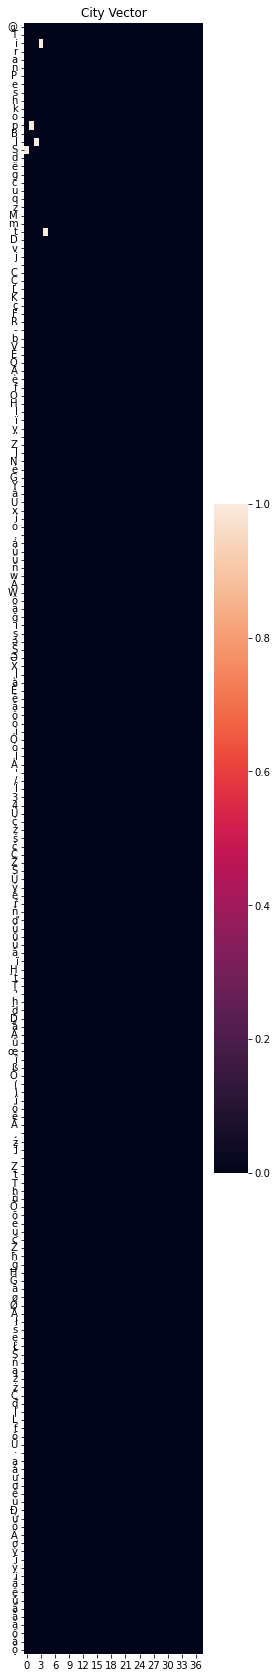

In [32]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

vectorized_city = vectorizer.vectorize("Split")
vectorized_city = torch.tensor(vectorized_city).unsqueeze(0)

plt.figure(figsize=(4, 30))
plt.title("City Vector")
sns.heatmap(vectorized_city.squeeze(0), yticklabels=vectorizer.city_vocab.ordered_tokens())
plt.show()

👍 pass vectorized city through all classifier's convolutional layers and plot their vectorization using heatmap. The last vector is feature vector.

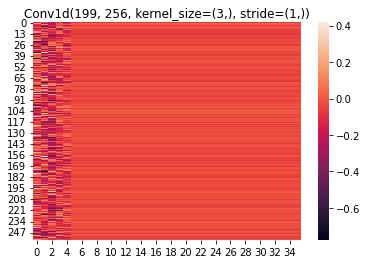

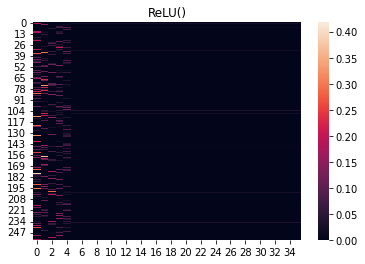

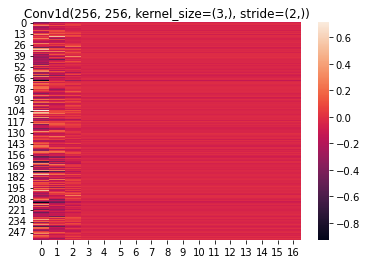

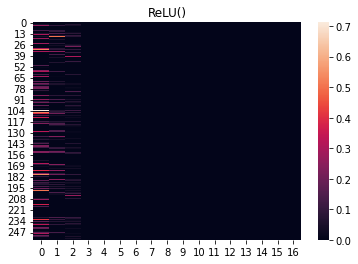

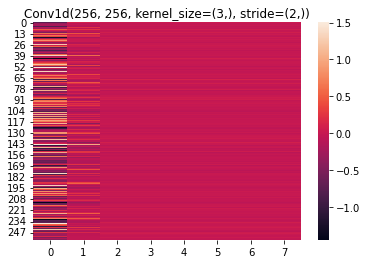

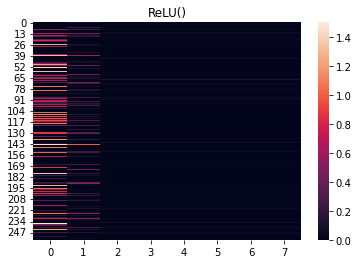

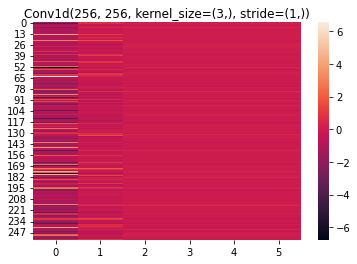

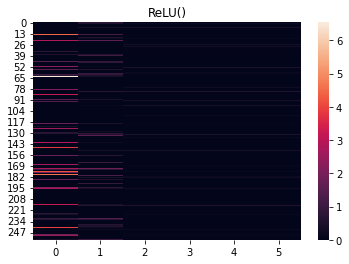

In [33]:
interim_vec = vectorized_city

for model in classifier.convnet:
    interim_vec = model(interim_vec)
    plt.title(str(model))
    sns.heatmap(interim_vec.squeeze(0).detach())
    plt.show()

👍 pass feature vector through classifier's fully connected layer and plot their vectorization using heatmap. One dimension should have country ticks. 

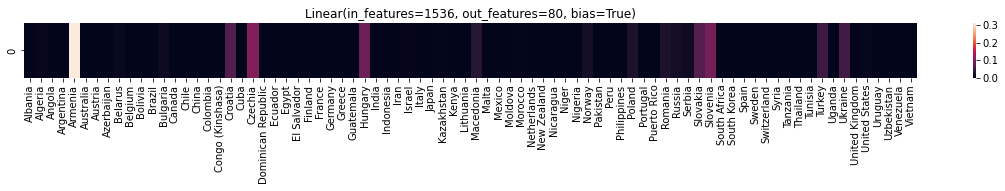

In [57]:
out_vec = F.softmax(classifier.fc(interim_vec.flatten(start_dim=1)), dim=1)

plt.figure(figsize=(20, 1))
plt.title(str(classifier.fc))
sns.heatmap(out_vec.detach(), xticklabels=vectorizer.country_vocab.ordered_tokens())
plt.show()